# Vertex AI: Qwik Start

## Learning objectives

* Train a TensorFlow model locally in a hosted [**Vertex Notebook**](https://cloud.google.com/vertex-ai/docs/general/notebooks?hl=sv).
* Create a [**managed Tabular dataset**](https://cloud.google.com/vertex-ai/docs/training/using-managed-datasets?hl=sv) artifact for experiment tracking.


## Introduction: customer lifetime value (CLV) prediction with BigQuery and TensorFlow on Vertex AI

In this lab, you use [BigQuery](https://cloud.google.com/bigquery) for data processing and exploratory data analysis and the [Vertex AI](https://cloud.google.com/vertex-ai) platform to train and deploy a custom TensorFlow Regressor model to predict customer lifetime value (CLV). The goal of the lab is to introduce to Vertex AI through a high value real world use case - predictive CLV. You start with a local BigQuery and TensorFlow workflow that you may already be familiar with and progress toward training and deploying your model in the cloud with Vertex AI.

![Vertex AI](./images/vertex-ai-overview.png "Vertex AI Overview")

Vertex AI is Google Cloud's next generation, unified platform for machine learning development and the successor to AI Platform announced at Google I/O in May 2021. By developing machine learning solutions on Vertex AI, you can leverage the latest ML pre-built components and AutoML to significantly enhance development productivity, the ability to scale your workflow and decision making with your data, and accelerate time to value.

### Predictive CLV: how much monetary value existing customers will bring to the business in the future

Predictive CLV is a high impact ML business use case. CLV is a customer's past value plus their predicted future value. The goal of predictive CLV is to predict how much monetary value a user will bring to the business in a defined future time range based on historical transactions.

By knowing CLV, you can develop positive ROI strategies and make decisions about how much money to invest in acquiring new customers and retaining existing ones to grow revenue and profit.

Once your ML model is a success, you can use the results to identify customers more likely to spend money than the others, and make them respond to your offers and discounts with a greater frequency. These customers, with higher lifetime value, are your main marketing target to increase revenue.

By using the machine learning approach to predict your customers' value you will use in this lab, you can prioritize your next actions, such as the following:

* Decide which customers to target with advertising to increase revenue.
* Identify which customer segments are most profitable and plan how to move customers from one segment to another.

Your task is to predict the future value for existing customers based on their known transaction history. 

![CLV](./images/clv-rfm.svg "Customer Lifetime Value")  
Source: [Cloud Architecture Center - Predicting Customer Lifetime Value with AI Platform: training the models](https://cloud.google.com/architecture/clv-prediction-with-offline-training-train)

There is a strong positive correlation between the recency, frequency, and amount of money spent on each purchase each customer makes and their CLV. Consequently, you leverage these features to in your ML model. For this lab, they are defined as:

* **Recency**: The time between the last purchase and today, represented by the distance between the rightmost circle and the vertical dotted line that's labeled "Now".
* **Frequency**: The time between purchases, represented by the distance between the circles on a single line.
* **Monetary**: The amount of money spent on each purchase, represented by the size of the circle. This amount could be the average order value or the quantity of products that the customer ordered.

## Setup

### Define constants

In [1]:
# Add installed library dependencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [2]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1'

In [3]:
# Create a globally unique Google Cloud Storage bucket for artifact storage.
GCS_BUCKET = f"{PROJECT_ID}-bucket"

In [4]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://qwiklabs-gcp-04-fa14b1bb0f75-bucket/...


### Import libraries

In [5]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from google.cloud import aiplatform

2023-03-26 09:45:59.113011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 09:46:01.034082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-26 09:46:01.034295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### Initialize the Vertex Python SDK client

Import the Vertex SDK for Python into your Python environment and initialize it.

In [6]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

## Download and process the lab data into BigQuery

### Dataset

In this lab, you use the publicly available [Online Retail data set](https://archive.ics.uci.edu/ml/datasets/online+retail) from the UCI Machine Learning Repository. This dataset contains 541,909 transnational customer transactions occuring between (YYYY-MM-DD) 2010-12-01 and 2011-12-09 for a UK-based and registered non-store retailer. The company primarily sells unique all-occasion gifts. Many of the company's customers are wholesalers.

**Citation**  
Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

This lab is also inspired by the Google Cloud Architect Guide Series [Predicting Customer Lifetime Value with AI Platform: introduction](https://cloud.google.com/architecture/clv-prediction-with-offline-training-intro).

### Data ingestion

Execute the command below to ingest the lab data from the UCI Machine Learning repository into `Cloud Storage` and then upload to `BigQuery` for data processing. The data ingestion and processing scripts are available under the `utils` folder in the lab directory.

In [7]:
# BigQuery constants. Please leave these unchanged.
BQ_DATASET_NAME="online_retail"
BQ_RAW_TABLE_NAME="online_retail_clv_raw"
BQ_CLEAN_TABLE_NAME="online_retail_clv_clean"
BQ_ML_TABLE_NAME="online_retail_clv_ml"
BQ_URI=f"bq://{PROJECT_ID}.{BQ_DATASET_NAME}.{BQ_ML_TABLE_NAME}"

**Note**: This Python script will take about 2-3 min to download and process the lab data file. Follow along with logging output in the cell below.

In [8]:
!python utils/data_download.py \
  --PROJECT_ID={PROJECT_ID} \
  --GCS_BUCKET={GCS_BUCKET} \
  --BQ_RAW_TABLE_NAME={BQ_RAW_TABLE_NAME} \
  --BQ_CLEAN_TABLE_NAME={BQ_CLEAN_TABLE_NAME} \
  --BQ_ML_TABLE_NAME={BQ_ML_TABLE_NAME} \
  --URL="https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online Retail.xlsx"


 2023-03-26 09:47:52,568 [INFO] Downloading xlsx file...
100% [....................................................] 23715344 / 23715344
 2023-03-26 09:47:53,712 [INFO] Converting xlsx -> csv...

 2023-03-26 09:49:07,118 [INFO] Uploading local csv file to GCS...

 2023-03-26 09:49:07,521 [INFO] Copied local csv file to GCS.

 2023-03-26 09:49:07,542 [INFO] Cleaning up local tmp data directory...

 2023-03-26 09:49:07,583 [INFO] Initializing BigQuery dataset.

 2023-03-26 09:49:08,160 [INFO] Created dataset qwiklabs-gcp-04-fa14b1bb0f75.online_retail

 2023-03-26 09:49:08,824 [INFO] BQ raw dataset load job starting...

 2023-03-26 09:49:15,672 [INFO] BQ raw dataset load job complete.

 2023-03-26 09:49:15,961 [INFO] Loaded 541909 rows into qwiklabs-gcp-04-fa14b1bb0f75.online_retail.online_retail_clv_raw.

 2023-03-26 09:49:15,971 [INFO] BQ make clean dataset starting...

 2023-03-26 09:49:20,157 [INFO] BQ make clean dataset complete

 2023-03-26 09:49:20,368 [INFO] Loaded 16766 rows int

### Data processing

As is the case with many real-world datasets, the lab dataset required some cleanup for you to utilize this historical customer transaction data for predictive CLV.

The following changes were applied:

* Keep only records that have a Customer ID.
* Aggregate transactions by day from Invoices.
* Keep only records that have positive order quantities and monetary values.
* Aggregate transactions by Customer ID and compute recency, frequency, monetary features as well as the prediction target.

**Features**:
- `customer_country` (CATEGORICAL): customer purchase country.
- `n_purchases` (NUMERIC): number of purchases made in feature window. (frequency)
- `avg_purchase_size` (NUMERIC): average unit purchase count in feature window. (monetary)
- `avg_purchase_revenue` (NUMERIC): average GBP purchase amount in in feature window. (monetary)
- `customer_age` (NUMERIC): days from first purchase in feature window.
- `days_since_last_purchase` (NUMERIC): days from the most recent purchase in the feature window. (recency)  

**Target**: 
- `target_monetary_value_3M` (NUMERIC): customer revenue from the entire study window including feature and prediction windows.

Note: This lab demonstrates a simple way to use a DNN predict customer 3-month ahead CLV monetary value based solely on the available dataset historical transaction history. Additional factors to consider in practice when using CLV to inform interventions include customer acquisition costs, profit margins, and discount rates to arrive at the present value of future customer cash flows. One of a DNN's benefits over traditional probabilistic modeling approaches is their ability to incorporate additional categorical and unstructured features; this is a great feature engineering opportunity to explore beyond this lab which just explores the RFM numeric features.

## Exploratory data analysis (EDA) in BigQuery

Below you use BigQuery from this notebook to do exploratory data analysis to get to know this dataset and identify opportunities for data cleanup and feature engineering.

### Recency: how recently have customers purchased?

In [9]:
%%bigquery recency

SELECT 
  days_since_last_purchase
FROM 
  `online_retail.online_retail_clv_ml`

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
recency.describe()

,days_since_last_purchase
count,3330.000000
mean,92.521021
std,77.240666
min,0.000000
25%,27.000000
50%,73.000000
75%,146.750000
max,274.000000


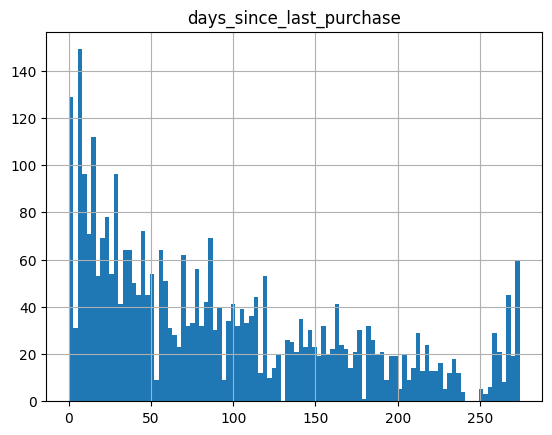

In [11]:
recency.hist(bins=100);

From the chart, there are clearly a few different customer groups here such as loyal customers that have made purchases in the last few days as well as inactive customers that have not purchased in 250+ days. Using CLV predictions and insights, you can strategize on marketing and promotional interventions to improve customer purchase recency and re-active dormant customers.

### Frequency: how often are customers purchasing?

In [12]:
%%bigquery frequency

SELECT
  n_purchases
FROM
  `online_retail.online_retail_clv_ml`

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
frequency.describe()

,n_purchases
count,3330.000000
mean,3.134234
std,4.504362
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,81.000000


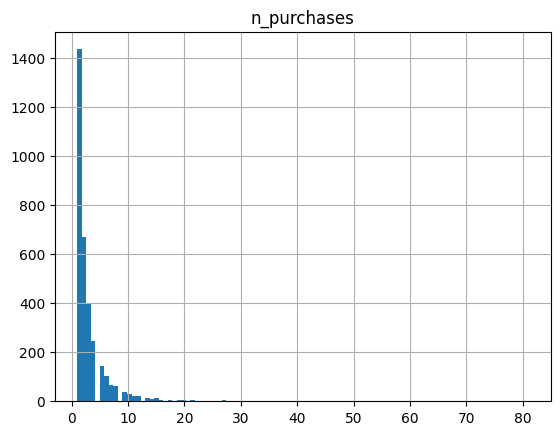

In [14]:
frequency.hist(bins=100);

From the chart and quantiles, you can see that half of the customers have less than or equal to only 2 purchases. You can also tell from the average purchases > median purchases and max purchases of 81 that there are customers, likely wholesalers, who have made significantly more purchases. This should have you already thinking about feature engineering opportunities such as bucketizing purchases and removing or clipping outlier customers. You can also explore alternative modeling strategies for CLV on new customers who have only made 1 purchase as the approach demonstrated in this lab will perform better on customers with more relationship transactional history. 

### Monetary: how much are customers spending?

In [15]:
%%bigquery monetary

SELECT
  target_monetary_value_3M
FROM
`online_retail.online_retail_clv_ml`

Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
monetary.describe()

,target_monetary_value_3M
count,3330.000000
mean,2355.838718
std,9445.870149
min,2.900000
25%,346.695000
50%,826.525000
75%,1977.495000
max,268478.000000


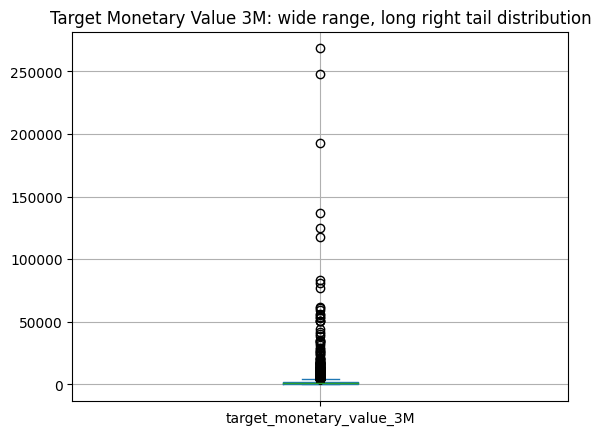

In [17]:
monetary['target_monetary_value_3M'].plot(kind='box', title="Target Monetary Value 3M: wide range, long right tail distribution", grid=True);

From the chart and summary statistics, you can see there is a wide range in customer monetary value ranging from 2.90 to 268,478 GBP. Looking at the quantiles, it is clear there are a few outlier customers whose monetary value is greater than 3 standard deviations from the mean. With this small dataset, it is recommended to remove these outlier customer values to treat separately, change your model's loss function to be more resistant to outliers, log the target feature, or clip their values to a maximum threshold. You should also be revisiting your CLV business requirements to see if binning customer monetary value and reframing this as a ML classification problem would suit your needs.

### Establish a simple model performance baseline

In order to evaluate the performance of your custom TensorFlow DNN Regressor model you will build in the next steps, it is a ML best practice to establish a simple performance baseline. Below is a simple SQL baseline that multiplies a customer's average purchase spent compounded by their daily purchase rate and computes standard regression metrics.

In [18]:
%%bigquery

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `online_retail.online_retail_clv_ml`
  LEFT JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

# Calculate overall baseline regression metrics.
SELECT
  ROUND(AVG(ABS(predicted_monetary_value_3M - target_monetary_value_3M)), 2) AS MAE,
  ROUND(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2)), 2) AS MSE,
  ROUND(SQRT(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2))), 2) AS RMSE
FROM
  predicted_clv

Query is running:   0%|          |

Downloading:   0%|          |

,MAE,MSE,RMSE
0,1762.06,81502420.93,9027.87


These baseline results provide further support for the strong impact of outliers. The extremely high MSE comes from the exponential penalty applied to missed predictions and the magnitude of error on a few predictions.

Next, you should look to plot the baseline results to get a sense of opportunity areas for you ML model.

In [19]:
%%bigquery baseline

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `online_retail.online_retail_clv_ml`
  INNER JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

SELECT
 *
FROM
  predicted_clv

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
baseline.head()

,customer_id,predicted_monetary_value_3M,target_monetary_value_3M
0,13099.0,414.72,207.36
1,12739.0,1951.08,1013.04
2,13147.0,237.60,712.80
3,13276.0,274.76,590.93
4,14420.0,775.04,387.52


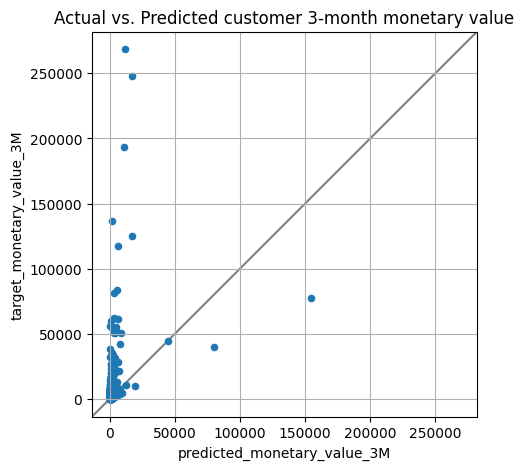

In [21]:
ax = baseline.plot(kind='scatter',
                   x='predicted_monetary_value_3M', 
                   y='target_monetary_value_3M',
                   title='Actual vs. Predicted customer 3-month monetary value',
                   figsize=(5,5),
                   grid=True)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.5, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims);

## Train a TensorFlow model locally

Now that you have a simple baseline to benchmark your performance against, train a TensorFlow Regressor to predict CLV.

In [22]:
%%bigquery

SELECT data_split, COUNT(*)
FROM `online_retail.online_retail_clv_ml`
GROUP BY data_split

Query is running:   0%|          |

Downloading:   0%|          |

,data_split,f0_
0,TRAIN,2638
1,TEST,339
2,VALIDATE,353


In [23]:
%%bigquery clv

SELECT *
FROM `online_retail.online_retail_clv_ml`

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
clv_train = clv.loc[clv.data_split == 'TRAIN', :]
clv_dev = clv.loc[clv.data_split == 'VALIDATE', :]
clv_test = clv.loc[clv.data_split == 'TEST', :]

In [25]:
# Model training constants.
# Virtual epochs design pattern:
# https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730
N_TRAIN_EXAMPLES = 2638
STOP_POINT = 20.0
TOTAL_TRAIN_EXAMPLES = int(STOP_POINT * N_TRAIN_EXAMPLES)
BATCH_SIZE = 32
N_CHECKPOINTS = 10
STEPS_PER_EPOCH = (TOTAL_TRAIN_EXAMPLES // (BATCH_SIZE*N_CHECKPOINTS))

NUMERIC_FEATURES = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
]

LABEL = "target_monetary_value_3M"

In [26]:
def df_dataset(df):
    """Transform Pandas Dataframe to TensorFlow Dataset."""
    return tf.data.Dataset.from_tensor_slices((df[NUMERIC_FEATURES].to_dict('list'), df[LABEL].values))

In [27]:
trainds = df_dataset(clv_train).prefetch(1).batch(BATCH_SIZE).repeat()
devds = df_dataset(clv_dev).prefetch(1).batch(BATCH_SIZE)
testds = df_dataset(clv_test).prefetch(1).batch(BATCH_SIZE)

2023-03-26 09:57:01.812510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-26 09:57:01.812585: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-26 09:57:01.812625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vertex-ai-qwiklab): /proc/driver/nvidia/version does not exist
2023-03-26 09:57:01.870323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

In [28]:
def rmse(y_true, y_pred):
    """Custom RMSE regression metric."""
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model():
    """Build and compile a TensorFlow Keras Regressor."""
    # Define input feature tensors and input layers.
    feature_columns = [
        tf.feature_column.numeric_column(key=feature)
        for feature in NUMERIC_FEATURES
    ]
    
    input_layers = {
        feature.key: tf.keras.layers.Input(name=feature.key, shape=(), dtype=tf.float32)
        for feature in feature_columns
    }
     
    # Keras Functional API: https://keras.io/guides/functional_api
    inputs = tf.keras.layers.DenseFeatures(feature_columns, name='inputs')(input_layers)
    d1 = tf.keras.layers.Dense(256, activation=tf.nn.relu, name='d1')(inputs)
    d2 = tf.keras.layers.Dropout(0.2, name='d2')(d1)  
    # Note: the single neuron output for regression.
    output = tf.keras.layers.Dense(1, name='output')(d2)
    
    model = tf.keras.Model(input_layers, output, name='online-retail-clv')
    
    optimizer = tf.keras.optimizers.Adam(0.001)    
    
    # Note: MAE loss is more resistant to outliers than MSE.
    model.compile(loss=tf.keras.losses.MAE,
                  optimizer=optimizer,
                  metrics=[['mae', 'mse', rmse]])
    
    return model

model = build_model()

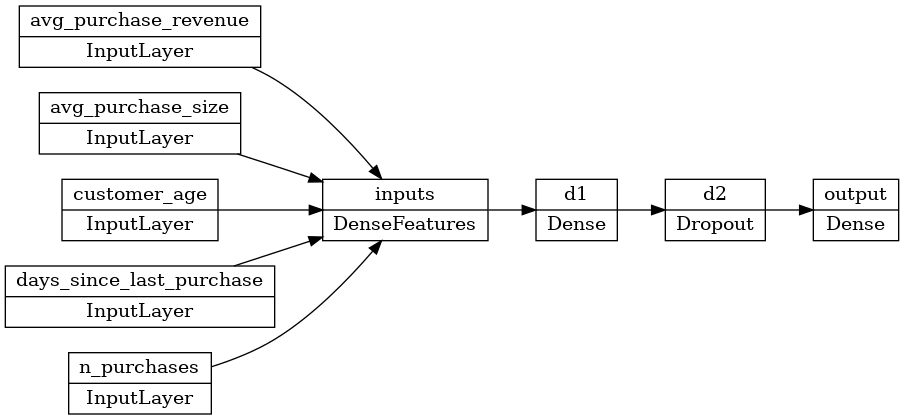

In [29]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./local-training/tensorboard',
    histogram_freq=1)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./local-training/checkpoints',
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

In [31]:
history = model.fit(trainds,
                    validation_data=devds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=N_CHECKPOINTS,
                    callbacks=[[tensorboard_callback,
                                earlystopping_callback,
                                checkpoint_callback]])

Epoch 1/10
164/164 [==============================] - 2s 6ms/step - loss: 1957.9945 - mae: 1957.9945 - mse: 106372192.0000 - rmse: 5012.5244 - val_loss: 1173.1133 - val_mae: 1173.1133 - val_mse: 12852195.0000 - val_rmse: 2336.4358
Epoch 2/10
164/164 [==============================] - 1s 3ms/step - loss: 1662.1113 - mae: 1662.1113 - mse: 98604872.0000 - rmse: 4588.6460 - val_loss: 1080.7505 - val_mae: 1080.7505 - val_mse: 12572640.0000 - val_rmse: 2311.3027
Epoch 3/10
164/164 [==============================] - 1s 4ms/step - loss: 1592.5140 - mae: 1592.5140 - mse: 96091384.0000 - rmse: 4521.3359 - val_loss: 1042.3881 - val_mae: 1042.3881 - val_mse: 12840035.0000 - val_rmse: 2321.3320
Epoch 4/10
164/164 [==============================] - 1s 4ms/step - loss: 1564.6880 - mae: 1564.6880 - mse: 95416552.0000 - rmse: 4468.5703 - val_loss: 1022.6948 - val_mae: 1022.6948 - val_mse: 13012966.0000 - val_rmse: 2323.3542
Epoch 5/10
164/164 [==============================] - 1s 4ms/step - loss: 1535.

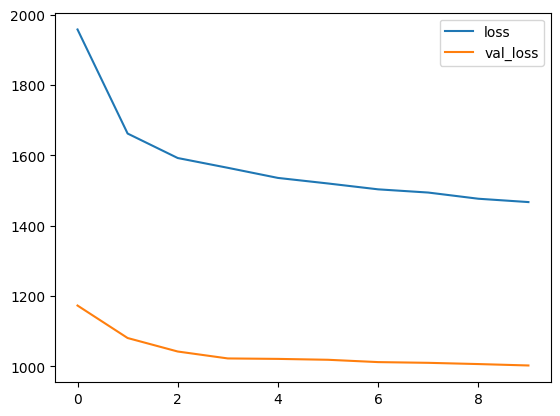

In [32]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot();

In [33]:
train_pred = model.predict(df_dataset(clv_train).prefetch(1).batch(BATCH_SIZE))
dev_pred = model.predict(devds)
test_pred = model.predict(testds)

11/11 [==============================] - 0s 4ms/step


In [34]:
train_results = pd.DataFrame({'actual': clv_train['target_monetary_value_3M'].to_numpy(), 'predicted': np.squeeze(train_pred)}, columns=['actual', 'predicted'])
dev_results = pd.DataFrame({'actual': clv_dev['target_monetary_value_3M'].to_numpy(), 'predicted': np.squeeze(dev_pred)}, columns=['actual', 'predicted'])
test_results = pd.DataFrame({'actual': clv_test['target_monetary_value_3M'].to_numpy(), 'predicted': np.squeeze(test_pred)}, columns=['actual', 'predicted'])

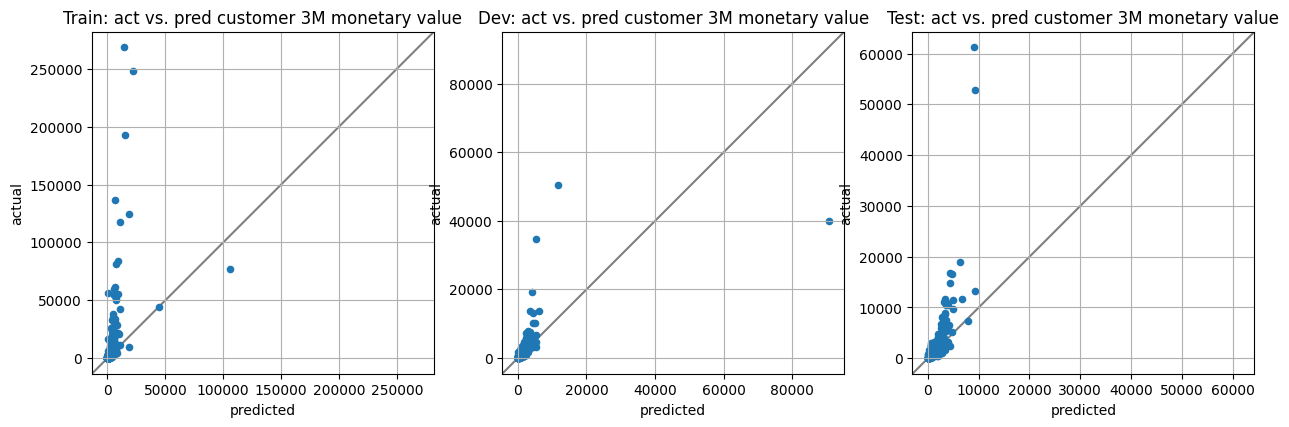

In [35]:
# Model prediction calibration plots.
fig, (train_ax, dev_ax, test_ax) = plt.subplots(1, 3, figsize=(15,15))

train_results.plot(kind='scatter',
                  x='predicted',
                  y='actual',
                  title='Train: act vs. pred customer 3M monetary value',
                  grid=True,
                  ax=train_ax)

train_lims = [
    np.min([train_ax.get_xlim(), train_ax.get_ylim()]),  # min of both axes
    np.max([train_ax.get_xlim(), train_ax.get_ylim()]),  # max of both axes
]

train_ax.plot(train_lims, train_lims, 'k-', alpha=0.5, zorder=0)
train_ax.set_aspect('equal')
train_ax.set_xlim(train_lims)
train_ax.set_ylim(train_lims)

dev_results.plot(kind='scatter',
                  x='predicted',
                  y='actual',
                  title='Dev: act vs. pred customer 3M monetary value',
                  grid=True,
                  ax=dev_ax)

dev_lims = [
    np.min([dev_ax.get_xlim(), dev_ax.get_ylim()]),  # min of both axes
    np.max([dev_ax.get_xlim(), dev_ax.get_ylim()]),  # max of both axes
]

dev_ax.plot(dev_lims, dev_lims, 'k-', alpha=0.5, zorder=0)
dev_ax.set_aspect('equal')
dev_ax.set_xlim(dev_lims)
dev_ax.set_ylim(dev_lims)

test_results.plot(kind='scatter',
                  x='predicted',
                  y='actual',
                  title='Test: act vs. pred customer 3M monetary value',
                  grid=True,
                  ax=test_ax)

test_lims = [
    np.min([test_ax.get_xlim(), test_ax.get_ylim()]),  # min of both axes
    np.max([test_ax.get_xlim(), test_ax.get_ylim()]),  # max of both axes
]

test_ax.plot(test_lims, test_lims, 'k-', alpha=0.5, zorder=0)
test_ax.set_aspect('equal')
test_ax.set_xlim(test_lims)
test_ax.set_ylim(test_lims);

You have trained a model better than your baseline. As indicated in the charts above, there is still additional feature engineering and data cleaning opportunities to improve your model's performance on customers with CLV. Some options include handling these customers as a separate prediction task, applying a log transformation to your target, clipping their value or dropping these customers all together to improve model performance.


## Next steps

Congratulations! In this lab, you walked through a machine learning experimentation workflow using Google Cloud's BigQuery for data storage and analysis and Vertex AI machine learning services to train and deploy a TensorFlow model to predict customer lifetime value

## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.